In [1]:
import sys
import os
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import networkx as nx
from sklearn import preprocessing
import selenium
import geopandas as gp

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import matrix_operation
import diffusionNMF
import grid_search
import nmf
from matrix_operation import mat_opr
from diffusionNMF import diffusionNMF
from grid_search import gridSearcher
from nmf import nmf

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_palette("colorblind")

In [13]:
# adjacency Laplacian
state_dset = pd.read_csv(os.path.join(par, 'collected_data/state_dataset.csv'), index_col = 0)
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0)
# json file with geographic info for each state -- required for graphing
state_map = os.path.join(par, 'collected_data/US_States_geojson.json')

In [4]:
#state_L = state_L.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)
#state_L = state_L.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 0)
#state_L = state_L.to_numpy()

#state_dset = state_dset.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)

In [14]:
K = np.linalg.inv(np.identity(len(state_L)) + 10 * state_L)
ks = preprocessing.MinMaxScaler().fit_transform(K)
diffuse = pd.DataFrame(ks, columns = state_dset.columns, index = state_dset.columns)

In [88]:
loc = 'Corpus Christi'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
m = folium.Map(titles = title_html, location=[41, -77], zoom_start=5.5)


#m.get_root().html.add_child(folium.Element(title_html))

folium.Choropleth(
geo_data=state_map,
data=diffuse["New York"],
key_on="feature.properties.NAME",
legend = True,
fill_color="YlOrRd",
fill_opacity=0.7,
line_opacity=0.2,
name = "",
overlay = True,
).add_to(m)

#folium.LayerControl().add_to(m)
m
m.save('NewYork_diff.html')

In [89]:
from selenium import webdriver
import time
driver = webdriver.Chrome()
driver.set_window_size(1000, 3000)  # choose a resolution
driver.get('file:///C:/Users/kq146/code/covid_college_tracker/Covid_data/analysis/NewYork_diff.html')
# You may need to add time.sleep(seconds) here
time.sleep(5)
#driver.save_screenshot('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/NewYork_diff.png')

True

### NMF Figures

In [6]:
# population data
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')
state_dset = mat_opr(state_dset)
# clean + normalize
state_iso = state_dset.iso()
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [7]:
errs = []
for r in range(1,20):
    nmfer = nmf(r, n_iter = 100000, tol = 1e-9)
    W,H = nmfer.fit_transform(state_norm.dataframe)
    err = np.linalg.norm(state_norm.dataframe - np.dot(W,H))/np.linalg.norm(state_norm.dataframe)
    errs.append(err)

Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance


In [8]:
errs = pd.DataFrame(errs)
errs.to_csv("./testing_data/nmf_rank_errors.csv")

In [9]:
errs = pd.read_csv("./testing_data/nmf_rank_errors.csv", index_col = 0)

In [10]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


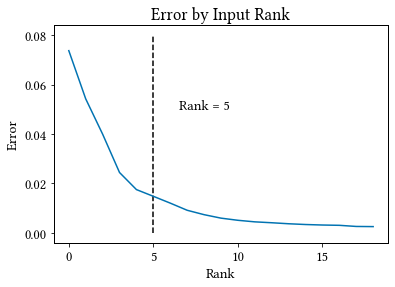

In [12]:
errs.plot(legend = False)
plt.xticks([0,5,10,15,20])
plt.yticks([0,0.02,0.04,0.06,0.08])
plt.vlines(x = 5, ymin = -0.0001, ymax = 0.08, colors = 'k', linestyles = '--', label = "rank = 6")
plt.ylabel("Error")
plt.xlabel("Rank")
plt.title("Error by Input Rank")
#plt.legend()
plt.text(6.5,0.05,"Rank = 5")
plt.savefig("test_fig.pdf")

In [36]:
rank = 4
nmfer = nmf(rank, n_iter = 100000, tol = 1e-9)
W,H = nmfer.fit_transform(state_norm.dataframe)

In [37]:
W = pd.DataFrame(W, index = state_norm.dataframe.index)
H = pd.DataFrame(H, columns = state_norm.dataframe.columns)

In [38]:
sns.set_palette("colorblind")

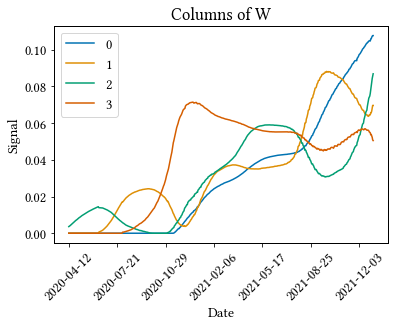

In [39]:
W.plot()
plt.xticks(rotation = 45)
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title("Columns of W")
plt.show()

In [30]:
state_map

'C:\\Users\\kq146\\code\\covid_college_tracker\\Covid_data\\collected_data/US_States_geojson.json'

<AxesSubplot:>

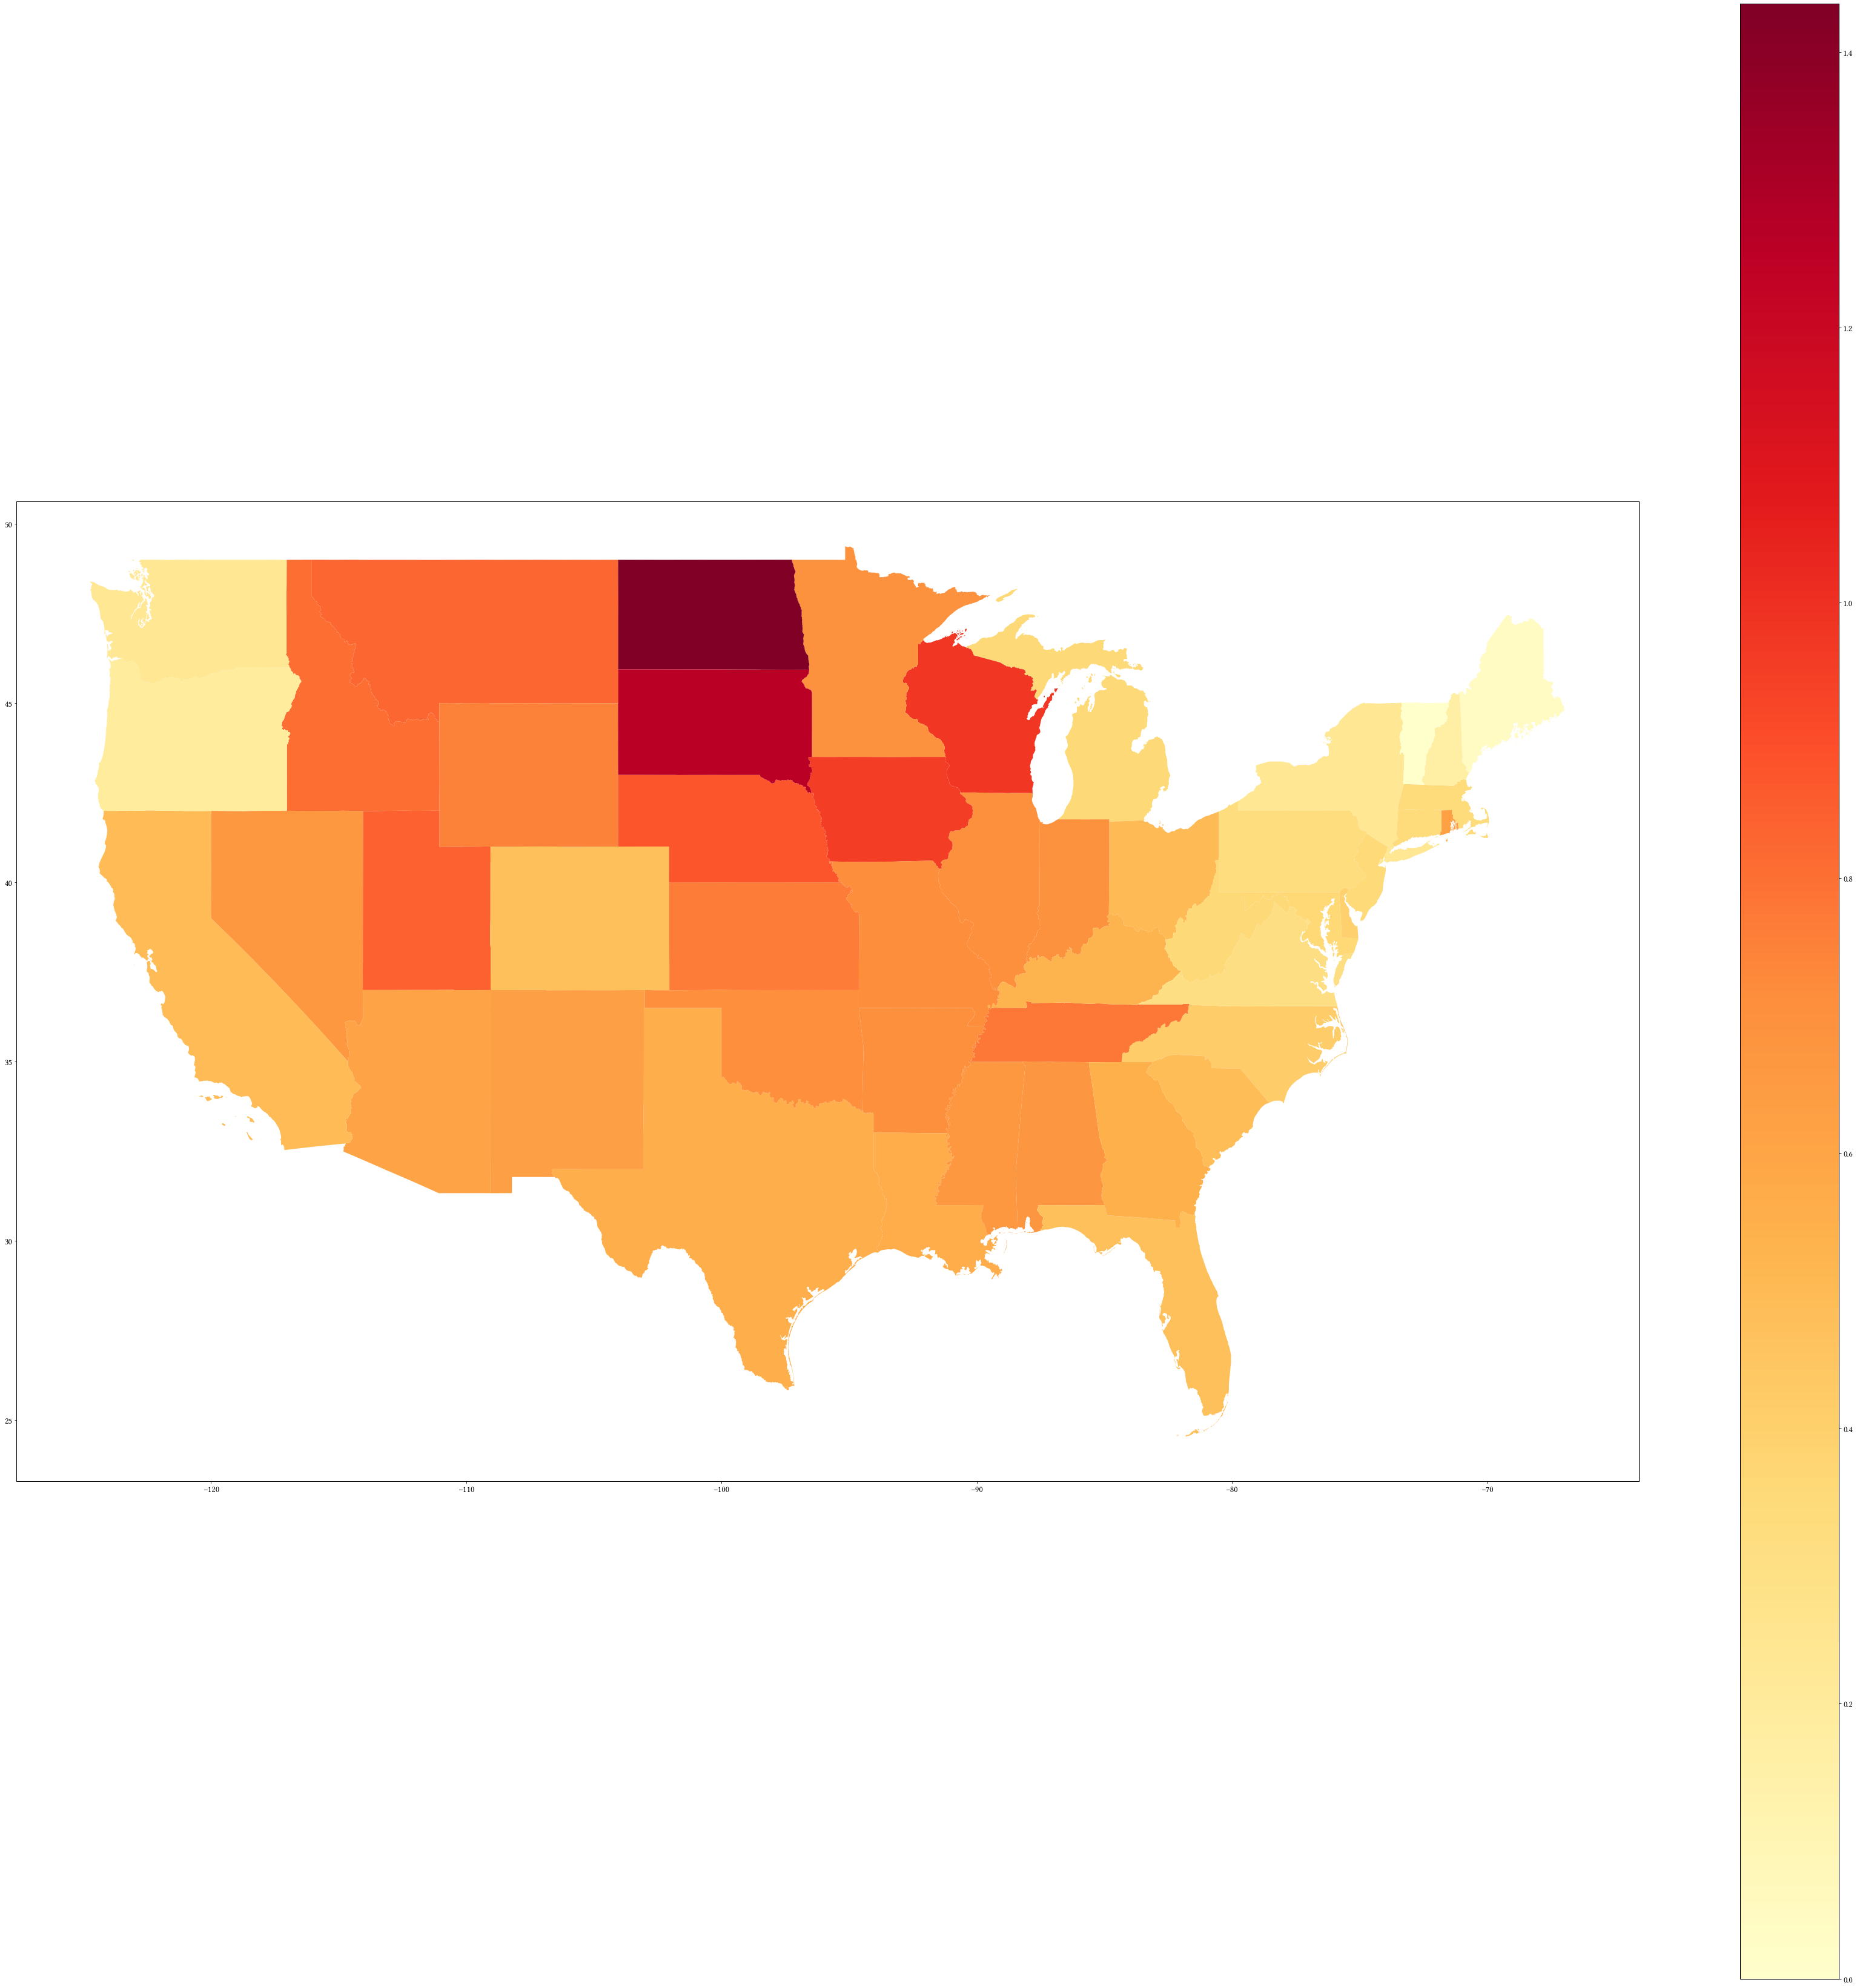

In [43]:
# json file with geographic info for each state -- required for geopandas
stateMap = gp.read_file(state_map)

H_col = []
for i in stateMap["NAME"]:
    try:
        H_col.append(H.loc[3,i])
    except:
        H_col.append(np.nan)

stateMap['val'] = H_col

# specific color map "Blues"
cmapper = mpl.cm.get_cmap('inferno')
cspace = np.linspace(0,0.99, 100)

#maxer = labels.max().max()
#minner = labels.min().min()


# plot using geopandas .plot()
stateMap.plot(column='val',legend=True, figsize=(60,60), cmap='YlOrRd')

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)

basis = H.loc[5,:] 

folium.Choropleth(
geo_data=state_map,
data=basis,
key_on="feature.properties.NAME",
legend = False,
fill_color="YlOrRd",
fill_opacity=0.7,
line_opacity=0.2,
name = "Basis ",
overlay = True,
).add_to(m)

folium.LayerControl().add_to(m)
m

## Counties

In [ ]:
def rescale(X,V,K = None):
    X = copy.deepcopy(X)
    V = copy.deepcopy(V)

    maxer = np.amax(X)
    X /= maxer
    V *= maxer
    
    return X,V

In [ ]:
# geo json map
county_map = os.path.join(par, 'collected_data/US_counties_geo.json')

# county laplacian
countyLaplacian = pd.read_csv(os.path.join(par, "collected_data/countyLaplacian.csv"), index_col = 0)
countyLaplacian.columns = countyLaplacian.columns.astype("int")

# county census data for normalization
county_pop = pd.read_csv(os.path.join(par, "collected_data/county_census.csv"), index_col = "fips")

### New England

In [ ]:
new_eng = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
new_eng = new_eng.loc[new_eng.index.get_level_values("state").isin(["New York", "Connecticut", "Maine", "Vermont",
                                                       "Massachusetts", "New Hampshire", "Rhode Island"])]
new_eng.index = new_eng.index.get_level_values("fips")
new_eng = new_eng.T

ne_lapl = countyLaplacian.loc[new_eng.columns,new_eng.columns].to_numpy()
ne_pop = county_pop.loc[new_eng.columns, :]

ne_map = os.path.join(par, 'collected_data/new_eng_counties_geo.json')

In [ ]:
# clean + normalize
new_eng_dset = mat_opr(new_eng)
new_eng_iso = new_eng_dset.iso()
pop_dict = {}
for col in new_eng_iso.dataframe.columns:
    pop_dict[col] = ne_pop.loc[col,'Population Estimate']        
    
new_eng_norm = new_eng_iso.population_normalizer(pop_dict)

In [ ]:
rank = 3
beta = 1
K = np.linalg.inv(np.identity(len(ne_lapl)) + beta * ne_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = K, n_iter = 500000  , tol = 1e-10)
X,V = dNMF.fit_transform(new_eng_norm.dataframe)

In [ ]:
X,V = rescale(X,V,K)
X = pd.DataFrame(X, index = new_eng_norm.dataframe.index)
V = pd.DataFrame(V, columns = new_eng_norm.dataframe.columns)

In [ ]:
nmfer = nmf(3, n_iter = 500000, tol = 1e-10)
W,H = nmfer.fit_transform(new_eng_norm.dataframe)

In [ ]:
W,H = rescale(W,H)
W = pd.DataFrame(W, index = new_eng_norm.dataframe.index)
H = pd.DataFrame(H, columns = new_eng_norm.dataframe.columns)